# NLP FINAL PROJECT
## Discriminatory Neural Network Training
### Keras Implementation

In [1]:
!git clone https://github.com/dai-anna/Duke-NLP-FinalProject.git
!cd Duke-NLP-FinalProject
!pip install pytorch-nlp


fatal: destination path 'Duke-NLP-FinalProject' already exists and is not an empty directory.


In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.layers.wrappers import Bidirectional
import torch
import torchnlp
import torch.nn as nn
import joblib
tf.random.set_seed(42)

In [3]:
def encode_dataframe(
    encoder, data, mode="pytorch"
):
    """Encode a dataframe with a given encoder. Splits and returns X and y separately."""
    encoded_tweets = [encoder.encode(tweet) for tweet in data["tweet"]]

    if mode == "sklearn":
        encoded_tweets = [
            " ".join(str(x) for x in encoded_tweets[idx].numpy())
            for idx in range(len(encoded_tweets))
        ]

    return encoded_tweets, data["hashtag"]

hashtags = [
    "crypto",
    "tesla",
    "gsw",
    "formula1",
    "thanksgiving",
    "holidays",
    "covid19",
]

In [4]:
# Load data from disk
encoder = joblib.load("Duke-NLP-FinalProject/artefacts/encoder.pickle")

train = pd.read_parquet("Duke-NLP-FinalProject/data/train.parquet")
val = pd.read_parquet("Duke-NLP-FinalProject/data/val.parquet")
test = pd.read_parquet("Duke-NLP-FinalProject/data/test.parquet")

train = train.assign(lenoftweet=train.tweet.apply(lambda x: len(x.split())))
train = train.query("lenoftweet <= 60")

xtrain, ytrain = encode_dataframe(encoder, data=train, mode="pytorch")
xval, yval = encode_dataframe(encoder, data=val, mode="pytorch")
xtest, ytest = encode_dataframe(encoder, data=test, mode="pytorch")

In [5]:
# Specify hyperparameters
embedding_dim = 32
hidden_size = 64
hidden_dense_dim = 32
dropout_rate = 0.5

batch_size = 64
num_epochs = 15
learning_rate = 10**-2.5

In [6]:
# Pad my input sequence with zeros
xtrain = nn.utils.rnn.pad_sequence(sequences=xtrain, batch_first=True, padding_value=0.0)
xval = nn.utils.rnn.pad_sequence(sequences=xval, batch_first=True, padding_value=0.0)
xtest = nn.utils.rnn.pad_sequence(sequences=xtest, batch_first=True, padding_value=0.0)


In [7]:
# Load data 

train_dataset = tf.data.Dataset.from_tensor_slices(
    (xtrain, ytrain.cat.codes.values)
).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((xval, yval.cat.codes.values)).batch(
    batch_size
)


In [8]:
# Train model
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=embedding_dim),
        keras.layers.Bidirectional(keras.layers.GRU(hidden_size, return_sequences=False, kernel_regularizer=keras.regularizers.L2(0))),
        # keras.layers.GRU(hidden_size, return_sequences=False, kernel_regularizer=keras.regularizers.L2(0)),
        keras.layers.Dropout(rate=dropout_rate),
        keras.layers.Dense(units=hidden_dense_dim, activation="relu", kernel_regularizer=keras.regularizers.L2(0)),
        keras.layers.Dropout(rate=dropout_rate),
        keras.layers.Dense(7, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"]
)

Epoch 1/15
270/270 [==============================] - 14s 36ms/step - loss: 1.3235 - accuracy: 0.4893 - val_loss: 0.9437 - val_accuracy: 0.6718
Epoch 2/15
270/270 [==============================] - 9s 33ms/step - loss: 0.8145 - accuracy: 0.7333 - val_loss: 0.8497 - val_accuracy: 0.7254
Epoch 3/15
270/270 [==============================] - 9s 33ms/step - loss: 0.6226 - accuracy: 0.7989 - val_loss: 0.9040 - val_accuracy: 0.7440
Epoch 4/15
270/270 [==============================] - 9s 33ms/step - loss: 0.5188 - accuracy: 0.8384 - val_loss: 0.8881 - val_accuracy: 0.7496
Epoch 5/15
270/270 [==============================] - 9s 33ms/step - loss: 0.4153 - accuracy: 0.8699 - val_loss: 0.9952 - val_accuracy: 0.7442
Epoch 6/15
270/270 [==============================] - 9s 33ms/step - loss: 0.3475 - accuracy: 0.8924 - val_loss: 1.1096 - val_accuracy: 0.7459
Epoch 7/15
270/270 [==============================] - 9s 33ms/step - loss: 0.2998 - accuracy: 0.9059 - val_loss: 1.2233 - val_accuracy: 0.736

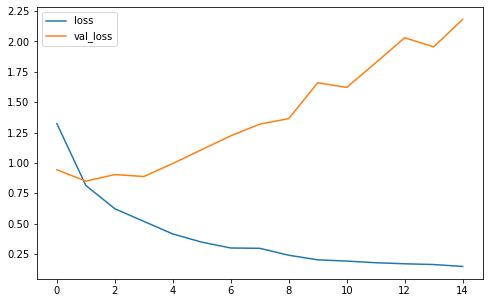

In [9]:
checkpoint_filepath = "Duke-NLP-FinalProject/data/trained_model/"
model_checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
)

model_checkpoint_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq="epoch",
)

hist = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs, callbacks=[model_checkpoint_loss, model_checkpoint_acc])

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)


pd.DataFrame(hist.history)[["loss", "val_loss"]].plot(figsize=(8, 5))


In [10]:
import math

import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import numpy as np

from tensorflow.keras.callbacks import LambdaCallback


class LRFinder:
    """
    Learning rate range test detailed in Cyclical Learning Rates for Training
    Neural Networks by Leslie N. Smith. The learning rate range test is a test
    that provides valuable information about the optimal learning rate. During
    a pre-training run, the learning rate is increased linearly or
    exponentially between two boundaries. The low initial learning rate allows
    the network to start converging and as the learning rate is increased it
    will eventually be too large and the network will diverge.
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.learning_rates = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

        loss = logs['loss']
        self.losses.append(loss)

        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, dataset, start_lr, end_lr, epochs=1,
             steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            raise Exception('To correctly train on the datagenerator,'
                            '`steps_per_epoch` cannot be None.'
                            'You can calculate it as '
                            '`np.ceil(len(TRAINING_LIST) / BATCH)`')

        self.lr_mult = (float(end_lr) /
                        float(start_lr)) ** (float(1) /
                                             float(epochs * steps_per_epoch))
        initial_weights = self.model.get_weights()

        original_lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                  logs: self.on_batch_end(batch, logs))

        self.model.fit(dataset,
                       epochs=epochs, callbacks=[callback], **kw_fit)
        self.model.set_weights(initial_weights)

        K.set_value(self.model.optimizer.lr, original_lr)

    def get_learning_rates(self):
        return(self.learning_rates)

    def get_losses(self):
        return(self.losses)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.learning_rates)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.learning_rates[n_skip_beginning:-n_skip_end][best_der_idx]

270/270 [==============================] - 8s 30ms/step - loss: 1.1731 - accuracy: 0.6363


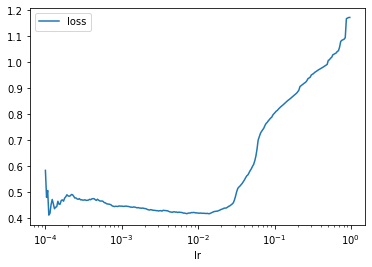

In [11]:
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(train_dataset, start_lr=0.0001, end_lr=1, batch_size=batch_size, epochs=1, steps_per_epoch=np.ceil(len(xtrain) / batch_size))

pd.DataFrame({
    "lr": lr_finder.get_learning_rates(),
    "loss": lr_finder.get_losses()
}).plot(x="lr", y="loss")
plt.xscale("log")
plt.show()